### Figure 1

Install and import all packages

In [2]:
import pickle
import invian
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from osfclient import OSF
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks, periodogram, spectrogram, filtfilt, butter, find_peaks_cwt, correlate, welch, peak_prominences, resample
from scipy.stats import ttest_rel, ttest_ind

warnings.filterwarnings("ignore")

plt.rcParams.update({
    'font.size': 32, 
    'figure.autolayout': True, 
    'lines.linewidth': 2, 
    'axes.spines.top': False, 
    'axes.spines.right': False
    })

events_fixed = False

print("The setup was successfully completed")

The setup was successfully completed


Define Functions

In [3]:
def pulse_split(event_ts, max_gap=0.3):
    counter = 1
    peak_dict = {}
    time_diff = np.diff(event_ts)
    i=0
    while True:
        
        c_diff = time_diff[i]
        if c_diff > max_gap:  
            if counter not in peak_dict.keys():
                peak_dict[counter] = []
            
            else:
                pass
            
            peak_dict[counter].append(event_ts[i])
            
            if i < (len(time_diff)-1):
                counter = 1
                i += 1
                
            else:
                break
        
        else:
            while c_diff < max_gap:
                counter += 1
                if i < (len(time_diff)-1):
                    i += 1
                    c_diff = time_diff[i]
                    
                else:
                    
                    break
                
        if not i < (len(time_diff)-1):   
            break

    return peak_dict

#Temp functions
def butter_filter(signal, filt_type, freqs, sr, order=3):
    b,a = butter(order, freqs, btype=filt_type, fs=sr)
    y=filtfilt(b, a, signal, padtype="even")
    
    return y

#Peri-event histogram for continuous values.
def contvar_peh(var_ts, var_vals, ref_ts, min_max, bin_width = False):
    r"""
    Function to perform a peri-event histogram of spiking activity.
    
    Parameters
    ----------
    var_ts : array-like
        Photometry signal timestamps
    var_vals : array-like
        Photometry signal values
    ref_ts : array-like
        Reference events that spiking will be aligned to
    min_max : tuple
        Time window in seconds around ref_ts to be analyzed in seconds. E.g. (-4,8)
    bin_width : float
        Bin width of histogram in seconds

    Returns
    ---------
    all_trials : 2d-array
        Continuous variable values around each timestamp in ref_ts in bin_width wide bins
    """
    if not isinstance(var_ts,np.ndarray):
        try:
            var_ts = np.array(var_ts)          
        except:
            raise TypeError(f"Expected spike_ts to be of type: array-like but got {type(var_ts)} instead")
        
    if not isinstance(var_vals,np.ndarray):
        try:
            var_vals = np.array(var_vals)          
        except:
            raise TypeError(f"Expected var_vals to be of type: array-like but got {type(var_vals)} instead")
    
    if not isinstance(ref_ts,np.ndarray):
        try:
            ref_ts = np.array(ref_ts)     
        except:
            raise TypeError(f"Expected spike_ts to be of type: array-like but got {type(ref_ts)} instead")
    
    if bin_width:
        ds_ts = np.linspace(var_ts.min(), var_ts.max(), int((var_ts.max()-var_ts.min())/bin_width))
        ds_vals = resample(var_vals, ds_ts.size)
            
        #ds_vals = np.interp(ds_ts, var_ts, var_vals)
        rate = bin_width
    
    else:
        rate = np.diff(var_ts).mean()
        ds_ts, ds_vals = (np.array(var_ts), np.array(var_vals))       
        
    left_idx = int(min_max[0]/rate)
    right_idx = int(min_max[1]/rate)

    event_ts = ref_ts[np.logical_and((ref_ts + min_max[0]) > ds_ts[0], (ref_ts + min_max[1]) < ds_ts[-1])]
    if len(event_ts) < len(ref_ts):
        event_diff = len(ref_ts) - len(event_ts)
        warnings.warn(f"The trial time range of {event_diff} events is outside the timestamps range. Events were ommitted.")
        
    
    all_idx = np.searchsorted(ds_ts,event_ts, "right")   
    all_trials = np.vstack([ds_vals[idx+left_idx:idx+right_idx] for idx in all_idx])
    
    return all_trials

Fetching the data from OSF and extracting the data

In [4]:
# Create output directory
output_dir = "osf_downloads"
os.makedirs(output_dir, exist_ok=True)

# Connect to OSF
osf = OSF()
project = osf.project('stk2r')
storage = project.storage('osfstorage')

# Set up folder name with data
target_filename = 'Behavioral_calcium.zip'

# Download zip file with data
for file in storage.files:
    if file.name == target_filename:
        output_path = os.path.join(output_dir, file.name)
        with open(output_path, 'wb') as f:
            file.write_to(f)
        print(f"Downloaded: {file.name} to {output_path}")
        break
else:
    print(f"File '{target_filename}' not found in OSF storage.")

#Set up 
zip_path = 'osf_downloads/behavioral_calcium.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Extracted all files to {output_dir}")

100%|██████████| 94.9M/94.9M [00:33<00:00, 2.87Mbytes/s]


Downloaded: Behavioral_calcium.zip to osf_downloads\Behavioral_calcium.zip
Extracted all files to osf_downloads


Formatting the data for analysis

In [5]:
fileloc = os.path.join(os.getcwd(), "osf_downloads", "Behavioral_calcium")

raw_data = {
    "D1-Cre": {
        "Saline": {
            "F488": pd.read_csv(fileloc + r"\saline_D1_F488_bandit_031825.csv"),
            "M690": pd.read_csv(fileloc + r"\saline_D1_M690_bandit_040325.csv"),
            "M700": pd.read_csv(fileloc + r"\saline_D1_M700_bandit_040325.csv"),
            "M780": pd.read_csv(fileloc + r"\saline_D1_M780_bandit_051325.csv"),
            "F797": pd.read_csv(fileloc + r"\saline_D1_F797_bandit_051325.csv"),
            },
        "MK801": {
            "F488": pd.read_csv(fileloc + r"\mk801_D1_F488_bandit_040425.csv"),
            "M690": pd.read_csv(fileloc + r"\mk801_D1_M690_bandit_042925.csv"),
            "M700": pd.read_csv(fileloc + r"\mk801_D1_M700_bandit_042525.csv"),
            "M780": pd.read_csv(fileloc + r"\mk801_D1_M780_bandit_060925.csv"),
            "F797": pd.read_csv(fileloc + r"\mk801_D1_F797_bandit_060925.csv")
            }
        },
    "A2a-Cre": {
        "Saline": {
            "M521": pd.read_csv(fileloc + r"\saline_A2a_M521_bandit_011025.csv"),
            "C139M1": pd.read_csv(fileloc + r"\saline_A2a_C139M1_bandit_041425.csv"),
            "C139M2": pd.read_csv(fileloc + r"\saline_A2a_C139M2_bandit_041425.csv"),
            "C139M4": pd.read_csv(fileloc + r"\saline_A2a_C139M4_bandit_040725.csv")
            },
        "MK801": {
            "M521": pd.read_csv(fileloc + r"\mk801_A2a_M521_bandit_030625.csv"),
            "C139M1": pd.read_csv(fileloc + r"\mk801_A2a_C139M1_bandit_050225.csv"),
            "C139M4": pd.read_csv(fileloc + r"\mk801_A2a_C139M4_bandit_042425.csv"),
            "C139M2": pd.read_csv(fileloc + r"\mk801_A2a_C139M2_bandit_042525.csv")
            }
        }
    }

events = {
    "D1-Cre": {
        "Saline": {
            "F488": pd.read_csv(fileloc + r"\events_saline_D1_F488_bandit_031825.csv", index_col=0),
            "M690": pd.read_csv(fileloc + r"\events_saline_D1_M690_bandit_040325.csv", index_col=0),
            "M700": pd.read_csv(fileloc + r"\events_saline_D1_M700_bandit_040325.csv", index_col=0),
            "M780": pd.read_csv(fileloc + r"\events_saline_D1_M780_bandit_051325.csv", index_col=0),
            "F797": pd.read_csv(fileloc + r"\events_saline_D1_F797_bandit_051325.csv", index_col=0)
            },
        "MK801": {
            "F488": pd.read_csv(fileloc + r"\events_mk801_D1_F488_bandit_040425.csv", index_col=0),
            "M690": pd.read_csv(fileloc + r"\events_mk801_D1_M690_bandit_042925.csv", index_col=0),
            "M700": pd.read_csv(fileloc + r"\events_mk801_D1_M700_bandit_042525.csv", index_col=0),
            "M780": pd.read_csv(fileloc + r"\events_mk801_D1_M780_bandit_060925.csv", index_col=0),
            "F797": pd.read_csv(fileloc + r"\events_mk801_D1_F797_bandit_060925.csv", index_col=0)
            }
        },
    "A2a-Cre": {
        "Saline": {
            "M521": pd.read_csv(fileloc + r"\events_saline_A2a_M521_bandit_011025.csv", index_col=0),
            "C139M1": pd.read_csv(fileloc + r"\events_saline_A2a_C139M1_bandit_041425.csv", index_col=0),
            "C139M2": pd.read_csv(fileloc + r"\events_saline_A2a_C139M2_bandit_041425.csv", index_col=0),
            "C139M4": pd.read_csv(fileloc + r"\events_saline_A2a_C139M4_bandit_040725.csv", index_col=0)
            },
        "MK801": {
            "M521": pd.read_csv(fileloc + r"\events_mk801_A2a_M521_bandit_030625.csv", index_col=0),
            "C139M4": pd.read_csv(fileloc + r"\events_mk801_A2a_C139M4_bandit_042425.csv", index_col=0),
            "C139M1": pd.read_csv(fileloc + r"\events_mk801_A2a_C139M1_bandit_050225.csv", index_col=0),
            "C139M2": pd.read_csv(fileloc + r"\events_mk801_A2a_C139M2_bandit_042525.csv", index_col=0)
            }
        }
    }

metadata = pd.read_csv(fileloc + r"\all_metadata_081425.csv")

print("All files were successfully formatted")

All files were successfully formatted


Visualize Raw data


Text(0.5, 1.0, 'Isosbestic Fluorescence')

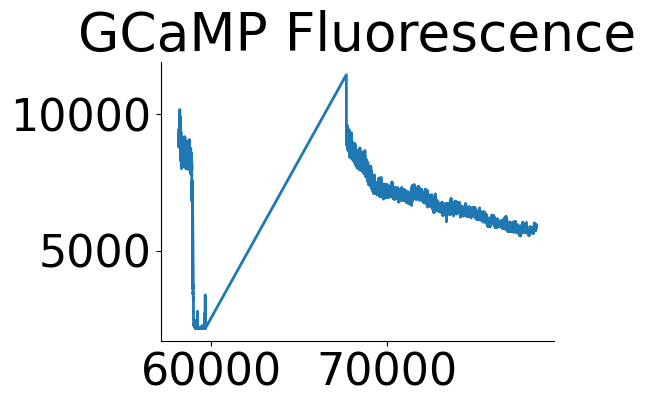

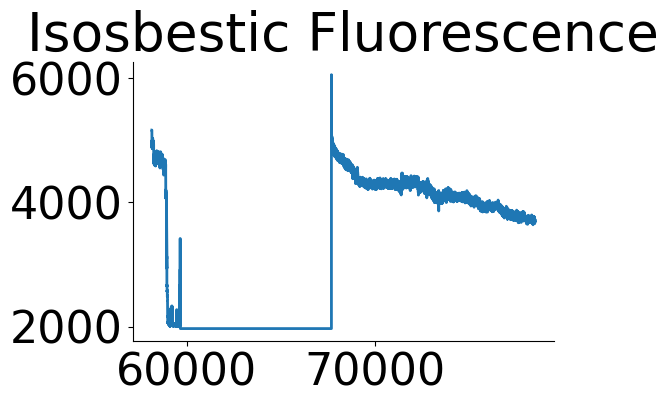

In [6]:
"""
There are:
Two strains: "D1-Cre" and "A2a-Cre"
Two treatments: "Saline", "MK801"
Nine mice: "F488", "M690", "M700", "M780", "F797", "M521", "C139M1", "C139M2", "C139M4".

A baseline of at least 15 mins. was first recorded for each mouse, then the mouse was injected. For most recordings, the mice were then placed back in their
home-cages for at least 30 mins, and then they were plugged back in to the photometry system and recording was continued.
"""
strain = "D1-Cre"
treatment = "Saline"
mouse = "M700"

c_t_data = raw_data[strain][treatment][mouse].copy(deep=True)
fig, ax = plt.subplots()
ax.plot(c_t_data["Time"], c_t_data["Fluorescence"])
ax.set_title("GCaMP Fluorescence")

fig, ax = plt.subplots()
ax.plot(c_t_data["Time"], c_t_data["Isosbestic"])
ax.set_title("Isosbestic Fluorescence")


Pre-process behavioral events

In [8]:
"""
The behavioral events were recorded using TTL pulses. Since it was all sent through one digital channel, a different number of pulses was sent for each event.
The rekey variable describes how many pulses were sent for each event. Here split the events. In some recordings, pulses were incorrect, such that both the 
pellet drop and the pellet retrieval both sent 6 pulses. Given that pellet retrieval always follows pellet drop, we can fix it.
"""
rekey = {1: "Left_poke", 2: "Right_poke", 3: "Rewarded", 4: "Unrewarded", 5: "Pellet_drop", 6: "Pellet_retrieval"}
p_events = {}
for strain in events:
    p_events[strain] = {}
    for treatment in events[strain]:
        p_events[strain][treatment] = {}
        for mouse in events[strain][treatment]:
            c_events = events[strain][treatment][mouse].to_numpy().squeeze()
            c_split = pulse_split(c_events)
            c_n_split = dict((rekey[key], value) for key,value in c_split.items())
            p_events[strain][treatment][mouse] = c_n_split
            
        for mouse in events[strain][treatment]:
            c_left_pokes = p_events[strain][treatment][mouse]["Left_poke"]
            c_right_pokes = p_events[strain][treatment][mouse]["Right_poke"]
            p_events[strain][treatment][mouse]["Pokes"] = c_left_pokes + c_right_pokes

#Fixing recordings where both pellet drop and retrieval had 6 pulses
p_events["D1-Cre"]["Saline"]["M690"]["Pellet_drop"] = p_events["D1-Cre"]["Saline"]["M690"]["Pellet_retrieval"][::2]
p_events["D1-Cre"]["Saline"]["M690"]["Pellet_retrieval"] = p_events["D1-Cre"]["Saline"]["M690"]["Pellet_retrieval"][1::2]

p_events["D1-Cre"]["Saline"]["M700"]["Pellet_drop"] = p_events["D1-Cre"]["Saline"]["M700"]["Pellet_retrieval"][::2]
p_events["D1-Cre"]["Saline"]["M700"]["Pellet_retrieval"] = p_events["D1-Cre"]["Saline"]["M700"]["Pellet_retrieval"][1::2]

p_events["A2a-Cre"]["Saline"]["C139M1"]["Pellet_drop"] = p_events["A2a-Cre"]["Saline"]["C139M1"]["Pellet_retrieval"][::2]
p_events["A2a-Cre"]["Saline"]["C139M1"]["Pellet_retrieval"] = p_events["A2a-Cre"]["Saline"]["C139M1"]["Pellet_retrieval"][1::2]

p_events["A2a-Cre"]["Saline"]["C139M2"]["Pellet_drop"] = p_events["A2a-Cre"]["Saline"]["C139M2"]["Pellet_retrieval"][::2]
p_events["A2a-Cre"]["Saline"]["C139M2"]["Pellet_retrieval"] = p_events["A2a-Cre"]["Saline"]["C139M2"]["Pellet_retrieval"][1::2]

p_events["A2a-Cre"]["Saline"]["C139M4"]["Pellet_drop"] = p_events["A2a-Cre"]["Saline"]["C139M4"]["Pellet_retrieval"][::2]
p_events["A2a-Cre"]["Saline"]["C139M4"]["Pellet_retrieval"] = p_events["A2a-Cre"]["Saline"]["C139M4"]["Pellet_retrieval"][1::2]

p_events["D1-Cre"]["MK801"]["M700"]["Pellet_drop"] = p_events["D1-Cre"]["MK801"]["M700"]["Pellet_retrieval"][::2]
p_events["D1-Cre"]["MK801"]["M700"]["Pellet_retrieval"] = p_events["D1-Cre"]["MK801"]["M700"]["Pellet_retrieval"][1::2]

p_events["A2a-Cre"]["MK801"]["C139M1"]["Pellet_drop"] = p_events["A2a-Cre"]["MK801"]["C139M1"]["Pellet_retrieval"][::2]
p_events["A2a-Cre"]["MK801"]["C139M1"]["Pellet_retrieval"] = p_events["A2a-Cre"]["MK801"]["C139M1"]["Pellet_retrieval"][1::2]
    
print("Behavioral events successfully pre-processed")


Behavioral events successfully pre-processed


Pre-process photometry data

In [10]:

"""
The photometry data is processed in the following manner.
A linear regression is used to fit the isosbestic data to the gcamp signal (noise_hat). The gcamp signal is processed as follows.
    norm_gcamp = (raw_gcamp - noise_hat) / noise_hat
This is analogous to a df/f given that the noise_hat represents the floor of the gcamp signal (f0). Importantly, the regression is fit on the
baseline data, and this fitted regression is used for the calculation of the df/f of both the baseline and the post-MK801 data.
This signal is then filtered using a bandpass digital filter that allows frequencies >0.005, <6 HZ.
"""

bp_filter = True

p_base_gcamp = {}
p_post_gcamp = {}
for strain in raw_data:
    p_base_gcamp[strain] = {}
    p_post_gcamp[strain] = {}
    for treatment in raw_data[strain]:
        p_base_gcamp[strain][treatment] = {}
        p_post_gcamp[strain][treatment] = {}
        for mouse in raw_data[strain][treatment]:
            #Here we get the corresponding raw data and metadata for each mouse
            c_meta = metadata[np.logical_and(metadata["Mouse"] == mouse, metadata["Treatment"] == treatment)]
            c_data = raw_data[strain][treatment][mouse]
            
            #Here we obtain the baseline 
            if not np.isnan(c_meta["Baseline_start"]).values:
                c_base_start_idx = np.searchsorted(c_data["Time"], c_meta["Baseline_start"].values)[0]
                c_base_end_idx = np.searchsorted(c_data["Time"], c_meta["Baseline_end"].values)[0]
            
                c_baseline = c_data.iloc[c_base_start_idx:c_base_end_idx,:]
                c_base_ts = c_baseline["Time"].to_numpy()
                c_base_gcamp = c_baseline["Fluorescence"].to_numpy()
                c_base_isos = c_baseline["Isosbestic"].to_numpy()
                c_sr = 1 / np.diff(c_base_ts).mean()
                
                #Here we fit the linear regression
                c_regr = LinearRegression()
                c_regr.fit(c_base_isos.reshape(-1,1), c_base_gcamp.reshape(-1,1))
                c_base_hat = c_regr.predict(c_base_isos.reshape(-1,1))[:,0]
                
                c_base_gcamp_norm = (c_base_gcamp - c_base_hat) / c_base_hat[0]
                
                #Here we apply the bandpass filter
                if bp_filter:
                    c_f_gcamp = butter_filter(c_base_gcamp_norm, "bandpass", (0.005, 6), c_sr)

                else:
                    c_f_gcamp = c_base_gcamp_norm    
                    
                p_base_gcamp[strain][treatment][mouse] = (c_base_ts, c_f_gcamp)
                

            c_post_start_idx = np.searchsorted(c_data["Time"], c_meta["Post_start"])[0]
            
            if not np.isnan(c_meta["Post_end"]).values:
                c_post_end_idx = np.searchsorted(c_data["Time"], c_meta["Post_end"])[0]
                c_post = c_data.iloc[c_post_start_idx: c_post_end_idx]
                
            else:
                c_post = c_data.iloc[c_post_start_idx:]                    
                
            c_post_ts = c_post["Time"].to_numpy()
            c_post_gcamp = c_post["Fluorescence"].to_numpy()
            c_post_isos = c_post["Isosbestic"].to_numpy()
            c_sr = 1 / np.diff(c_post_ts).mean()
            
            c_post_hat = c_regr.predict(c_post_isos.reshape(-1,1))[:,0]
            c_post_gcamp_norm = (c_post_gcamp - c_post_hat)/c_post_hat
            
            if bp_filter:
                c_f_gcamp = butter_filter(c_post_gcamp_norm, "high", 0.001, c_sr)
            else:
                c_f_gcamp = c_post_gcamp_norm
                
            p_post_gcamp[strain][treatment][mouse] = (c_post_ts, c_f_gcamp)

print("All photometry recordings where succesffully processed")

All photometry recordings where succesffully processed


Visualize the baseline and post-MK801 processed photometry signals

A2a-Cre Saline M521 has no baseline


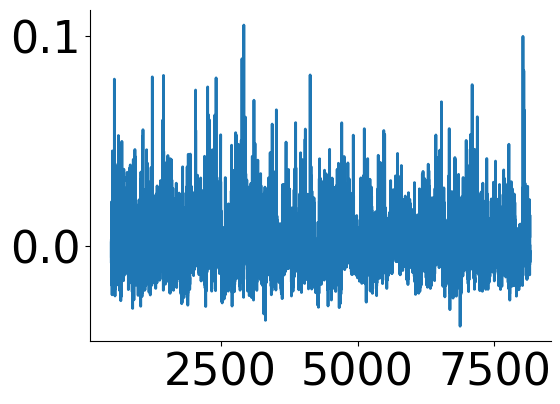

In [11]:
"""
There are:
Two strains: "D1-Cre" and "A2a-Cre"
Two treatments: "Saline", "MK801"
Nine mice: "F488", "M690", "M700", "M780", "F797", "M521", "C139M1", "C139M2", "C139M4".
"""

strain = "A2a-Cre"
treatment = "Saline"
mouse = "M521"

if mouse in p_base_gcamp[strain][treatment]:
    t_baseline = p_base_gcamp[strain][treatment][mouse]
    
    fig, ax = plt.subplots()
    ax.plot(t_baseline[0], t_baseline[1])
    
else:
    print(f"{strain} {treatment} {mouse} has no baseline")

if mouse in p_post_gcamp[strain][treatment]:
    t_post = p_post_gcamp[strain][treatment][mouse]
    
    fig, ax = plt.subplots()
    ax.plot(t_post[0], t_post[1])
    

Calculating peri-event histogram for all behavioral events

In [ ]:
#PEH window (in seconds) of each behavioral event 
event_windows = {
    "Left_poke": (-2,2),
    "Right_poke": (-2,2),
    "Pokes": (-2,2),
    "Rewarded": (-4,4),
    "Unrewarded": (-4,4),
    "Pellet_drop": (-10,15),
    "Pellet_retrieval": (-20,20)
    }
bin_width = 0.1
norm_bins = 50
event_pehs = {}
for strain in p_post_gcamp:
    event_pehs[strain] = {}
    
    for treatment in p_post_gcamp[strain]:
        event_pehs[strain][treatment] = {}
        
        for mouse in p_post_gcamp[strain][treatment]:
            #print(f"Calculating PEHs of {strain}, {treatment}, {mouse}")
            event_pehs[strain][treatment][mouse] = {}
            
            c_ts = p_post_gcamp[strain][treatment][mouse][0]
            c_gcamp = p_post_gcamp[strain][treatment][mouse][1]
            c_all_events = p_events[strain][treatment][mouse]
            
            for event_name in event_windows:
                c_event = c_all_events[event_name]
                c_window = event_windows[event_name]
                
                #c_peh = invian.contvar_peh(c_ts, c_gcamp, c_event, min_max=c_window, bin_width=bin_width)
                c_peh = contvar_peh(c_ts, c_gcamp, c_event, min_max=c_window, bin_width=bin_width)
                c_norm_peh = c_peh - (c_peh[:,:norm_bins].mean(axis=1)[:,np.newaxis])
                
                event_pehs[strain][treatment][mouse][event_name] = c_norm_peh

print("All PEHs have been successfully calculated")

All PEHs have been calculated


Visualizing PEH for each mouse

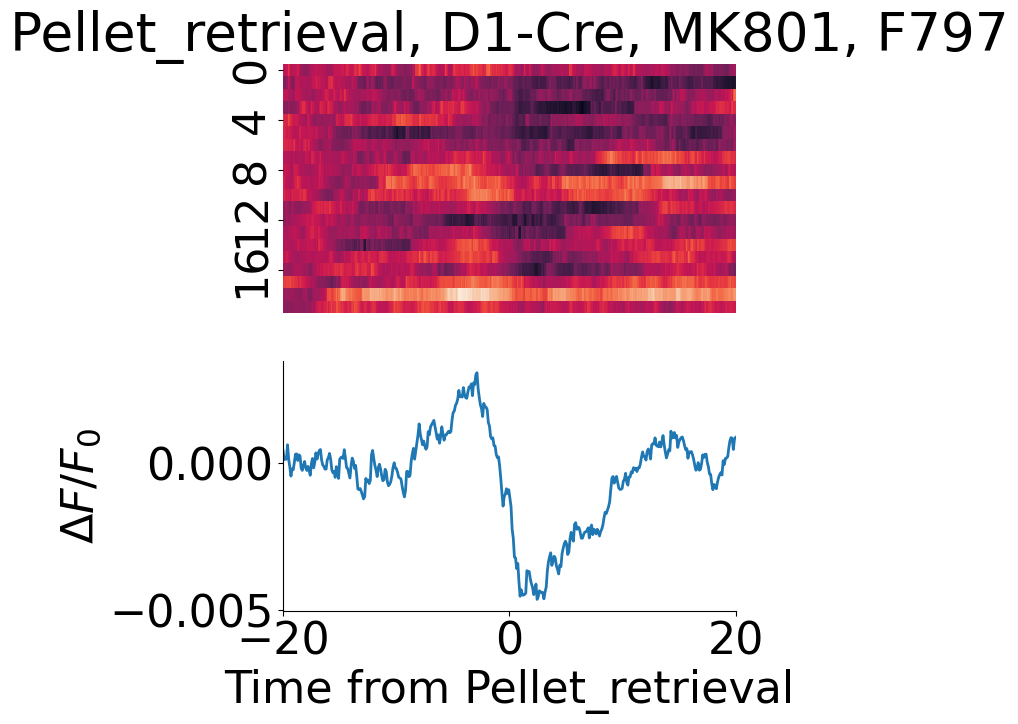

In [14]:
"""
There are:
5 Behavioral event: "Left_poke", "Right_poke", "Rewarded", "Unrewarded", "Pellet_drop", "Pellet_retrieval"
Two strains: "D1-Cre" and "A2a-Cre"
Two treatments: "Saline", "MK801"
Nine mice: "F488", "M690", "M700", "M780", "F797", "M521", "C139M1", "C139M2", "C139M4". See loading data cell to 
check which mice belong to which strain.
"""

#From the options, you can select the specific mouse
event_name = "Pellet_retrieval"
strain = "D1-Cre"
treatment = "MK801"
mouse = "F797"

c_window = event_windows[event_name]
if mouse == "all":
    c_data = event_pehs[strain][treatment]
    
    if (event_name == "Pellet_drop") or (event_name == "Pellet_retrieval"):
        y_lim = (-2,1)
    else:
        y_lim = (-0.5,1)
    
    for c_mouse in c_data:
        c_peh = event_pehs[strain][treatment][c_mouse][event_name]
        
        fig, ax = plt.subplots(2,1, figsize=(8,8))
        sns.heatmap(c_peh, ax=ax[0], cbar=False, xticklabels=False)
        ax[1].plot(np.linspace(c_window[0], c_window[1],c_peh.shape[1]), c_peh[:].mean(axis=0))
        #ax[1].set_xlim(c_window[0], c_window[1])
        ax[0].set_title(f"{event_name}, {strain}, {treatment}, {c_mouse}")
        #ax[1].set_ylim(y_lim[0], y_lim[1])
        ax[1].set_xlabel(f"Time from {event_name}")
        ax[1].set_ylabel("Z-Score")
        sns.despine(ax=ax[1])
        
else:
    c_peh = event_pehs[strain][treatment][mouse][event_name]
    
    if (event_name == "Pellet_drop") or (event_name == "Pellet_retrieval"):
        y_lim = (-2,1)
    else:
        y_lim = (-0.5,1)
    
    fig, ax = plt.subplots(2,1, figsize=(8,8))
    sns.heatmap(c_peh, ax=ax[0], cbar=False, xticklabels=False)
    ax[1].plot(np.linspace(c_window[0], c_window[1],c_peh.shape[1]), c_peh.mean(axis=0))
    ax[1].set_xlim(c_window[0], c_window[1])
    ax[0].set_title(f"{event_name}, {strain}, {treatment}, {mouse}")
    ax[1].set_xlabel(f"Time from {event_name}")
    ax[1].set_ylabel(r"$\Delta F/F_0$")
    sns.despine(ax=ax[1])

Calculate and plot average pellet retrieval response after saline and MK801 injections

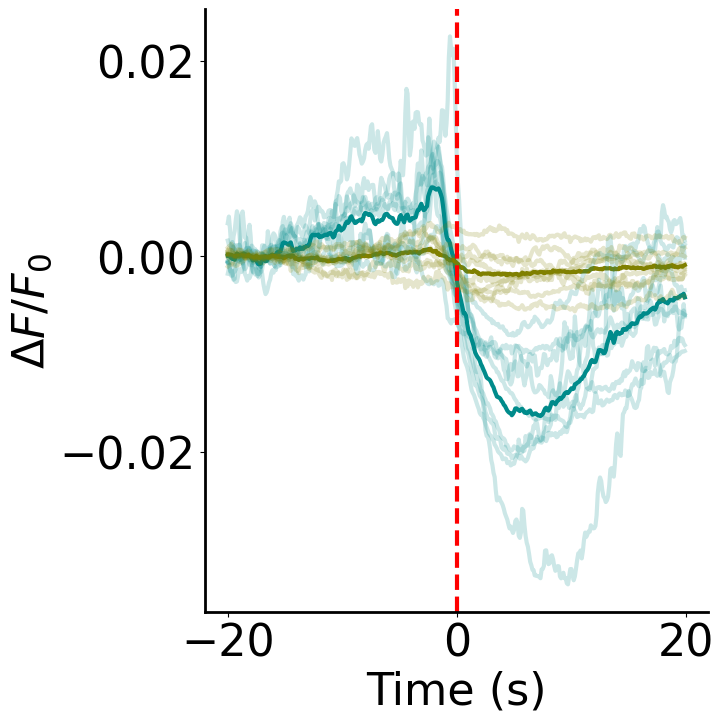

In [15]:
"""
We find the mean response for each mouse, and we pool and format the data for plotting.
"""

pr_bins = np.arange(event_windows["Pellet_retrieval"][0],event_windows["Pellet_retrieval"][1], 0.1)
all_pr_avgs = []
for strain in event_pehs:
    for treatment in event_pehs[strain]:
        for mouse in event_pehs[strain][treatment]:
            c_pr_peh = event_pehs[strain][treatment][mouse]["Pellet_retrieval"]
            c_pr_peh_avg = c_pr_peh.mean(axis=0)
            
            pr_peh_avg_df = pd.DataFrame({"Value": c_pr_peh_avg, "Time": pr_bins})
            pr_peh_avg_df = pr_peh_avg_df.assign(Strain=strain, Treatment=treatment, Mouse=mouse)
            all_pr_avgs.append(pr_peh_avg_df)
            
concat_pr_avgs = pd.concat(all_pr_avgs)
sal_pr_avgs = concat_pr_avgs[concat_pr_avgs["Treatment"] == "Saline"]
mk801_pr_avgs = concat_pr_avgs[concat_pr_avgs["Treatment"] == "MK801"]

#Plotting of the peri-event histogram
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x="Time", y="Value", hue="Treatment", data=concat_pr_avgs, errorbar=None, palette=["darkcyan", "olive"], linewidth=3, legend=False)
sns.lineplot(x="Time", y="Value", hue="Mouse", data=sal_pr_avgs, errorbar=None, palette=["darkcyan"], alpha=0.2, linewidth=3, legend=False)
sns.lineplot(x="Time", y="Value", hue="Mouse", data=mk801_pr_avgs, errorbar=None, palette=["olive"], alpha=0.2, linewidth=3, legend=False)
sns.despine()
ax.set_ylabel(r"$\Delta F/F_0$")
ax.set_xlabel("Time (s)")
ax.axvline(0, c="red", linestyle="--", linewidth=3)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)


Find the average pre-retrieval maximum response and post-retrieval minimum response and format for plotting and statistical testing

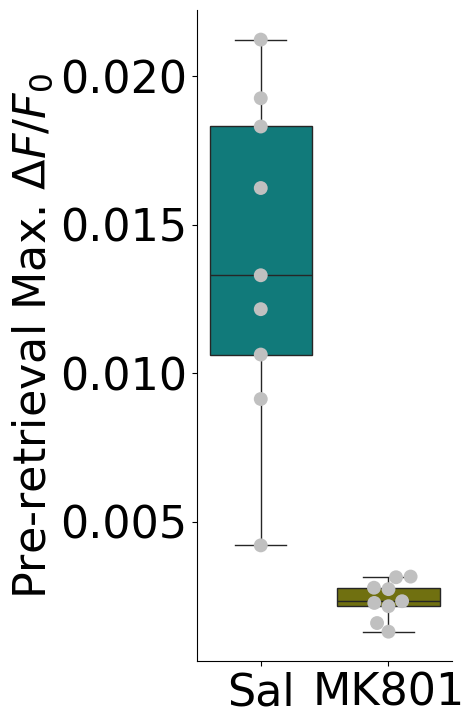

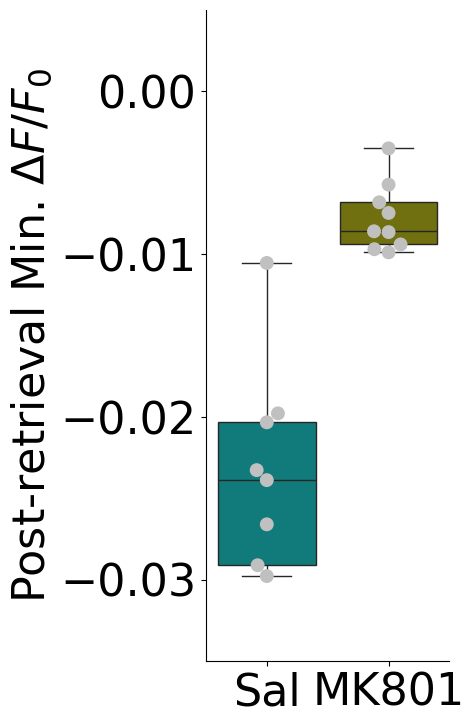

In [16]:
#We find the average maximum pre-retrieval and minimum post-retrieval responses
max_responses = []
for strain in event_pehs:
    for treatment in event_pehs[strain]:
        for mouse in event_pehs[strain][treatment]:
            for event in event_pehs[strain][treatment][mouse]:
                c_peh = event_pehs[strain][treatment][mouse][event]
                
                if event == "Pellet_retrieval":
                    c_max_pre = c_peh[:,70:100].max(axis=1)
                    c_max_pre_avg = c_max_pre.mean()
                    
                    c_inhibition = c_peh[:,100:].min(axis=1)
                    c_inhibition_avg = c_inhibition.mean()
                    
                    c_max_resp = pd.DataFrame({
                        "Mouse": mouse,
                        "Treatment": treatment,
                        "Strain": strain,
                        "Pre_max": [c_max_pre_avg],
                        "Post_min": [c_inhibition_avg]
                        })
                    
                    max_responses.append(c_max_resp)
                
concat_responses = pd.concat(max_responses)

#Plotting boxplot of maximum pre-retrieval response
fig, ax = plt.subplots(figsize=(5.5,8))
sns.boxplot(x="Treatment", y="Pre_max", data=concat_responses, palette=["darkcyan", "olive"])
sns.swarmplot(x="Treatment", y="Pre_max", data=concat_responses, palette=["silver"], s=10, dodge=False)
ax.set_xlabel("")
ax.set_ylabel(r"Pre-retrieval Max. $\Delta F/F_0$")
ax.set_xticklabels(["Sal", "MK801"])
sns.despine()

#Plotting boxplot of minimum post-retrieval response
fig, ax = plt.subplots(figsize=(5.5,8))
sns.boxplot(x="Treatment", y="Post_min", data=concat_responses, palette=["darkcyan", "olive"])
sns.swarmplot(x="Treatment", y="Post_min", data=concat_responses, palette=["silver"], s=10, dodge=False)
ax.set_xlabel("")
ax.set_ylabel(r"Post-retrieval Min. $\Delta F/F_0$")
ax.set_xticklabels(["Sal", "MK801"])
ax.set_yticks(np.arange(-0.03,0.01, 0.01))
ax.set_ylim(-0.035,0.005)
sns.despine()

#Statistical testing
pre_resp_ttest = ttest_rel(concat_responses["Pre_max"][concat_responses["Treatment"] == "Saline"], 
                           concat_responses["Pre_max"][concat_responses["Treatment"] == "MK801"])
post_resp_ttest = ttest_rel(concat_responses["Post_min"][concat_responses["Treatment"] == "Saline"], 
                            concat_responses["Post_min"][concat_responses["Treatment"] == "MK801"])